In [90]:
# standard 
import os
import datetime as dt
from math import *

# external
import numpy as np
import pandas as pd

# Stats
from statsmodels.tsa.stattools import adfuller
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')
palette = sns.color_palette("rocket_r")

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# # Deep learning
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import LSTM, Dense, Input

# Tracking experiments
import mlflow.sklearn




def moon_phase(month, day, year):
    ages = [18, 0, 11, 22, 3, 14, 25, 6, 17, 28, 9, 20, 1, 12, 23, 4, 15, 26, 7]
    offsets = [-1, 1, 0, 1, 2, 3, 4, 5, 7, 7, 9, 9]
    description = ["new (totally dark)",
      "waxing crescent (increasing to full)",
      "in its first quarter (increasing to full)",
      "waxing gibbous (increasing to full)",
      "full (full light)",
      "waning gibbous (decreasing from full)",
      "in its last quarter (decreasing from full)",
      "waning crescent (decreasing from full)"]
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    if day == 31:
        day = 1
    days_into_phase = ((ages[(year + 1) % 19] +
                        ((day + offsets[month-1]) % 30) +
                        (year < 1900)) % 30)
    index = int((days_into_phase + 2) * 16/59.0)
    #print(index)  # test
    if index > 7:
        index = 7
    status = description[index]

    # light should be 100% 15 days into phase
    light = int(2 * days_into_phase * 100/29)
    if light > 100:
        light = abs(light - 200);
    date = "%d%s%d" % (day, months[month-1], year)

    return date, status, light


# put in a date you want ...
# 26jan2009 is the start of the Chinese New Year for 2009
# the moon is at its lowest intensity
month = 1
day = 26
year = 2009  # use yyyy format

date, status, light = moon_phase(month, day, year)

In [60]:
df = pd.read_csv("./data/original_data/data.txt", sep = "     ",index_col = None)

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [61]:
df.head()

,COEF_MAREE UT: 0.0
2000-01-01 12:21:00,48
2000-01-02 00:53:00,50
2000-01-02 13:19:00,53
2000-01-03 01:45:00,56
2000-01-03 14:08:00,60


In [62]:
df.shape

(15292, 1)

In [63]:
df.reset_index(inplace = True)

In [64]:
df.columns

Index(['index', 'COEF_MAREE   UT: 0.0'], dtype='object')

In [65]:
df.rename(columns = {'index':'dateTime', 'COEF_MAREE   UT: 0.0':'coef'}, inplace = True)

In [66]:
df.head()

,dateTime,coef
0,2000-01-01 12:21:00,48
1,2000-01-02 00:53:00,50
2,2000-01-02 13:19:00,53
3,2000-01-03 01:45:00,56
4,2000-01-03 14:08:00,60


In [67]:
df.dtypes

dateTime    object
coef         int64
dtype: object

In [68]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

In [69]:
df['day'] = df['dateTime'].dt.day.values

In [70]:
df['month'] = df['dateTime'].dt.month.values

In [71]:
df['hour'] = df['dateTime'].dt.hour.values

In [72]:
df['year'] = df['dateTime'].dt.year.values

In [73]:
df['time'] = df["dateTime"].dt.time.values

In [74]:
df.head()

,dateTime,coef,day,month,hour,year,time
0,2000-01-01 12:21:00,48,1,1,12,2000,12:21:00
1,2000-01-02 00:53:00,50,2,1,0,2000,00:53:00
2,2000-01-02 13:19:00,53,2,1,13,2000,13:19:00
3,2000-01-03 01:45:00,56,3,1,1,2000,01:45:00
4,2000-01-03 14:08:00,60,3,1,14,2000,14:08:00


In [75]:
df[df["year"]==2021].month.unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [76]:
years = df["year"].unique()

In [77]:
df["year"].dtype

dtype('int64')

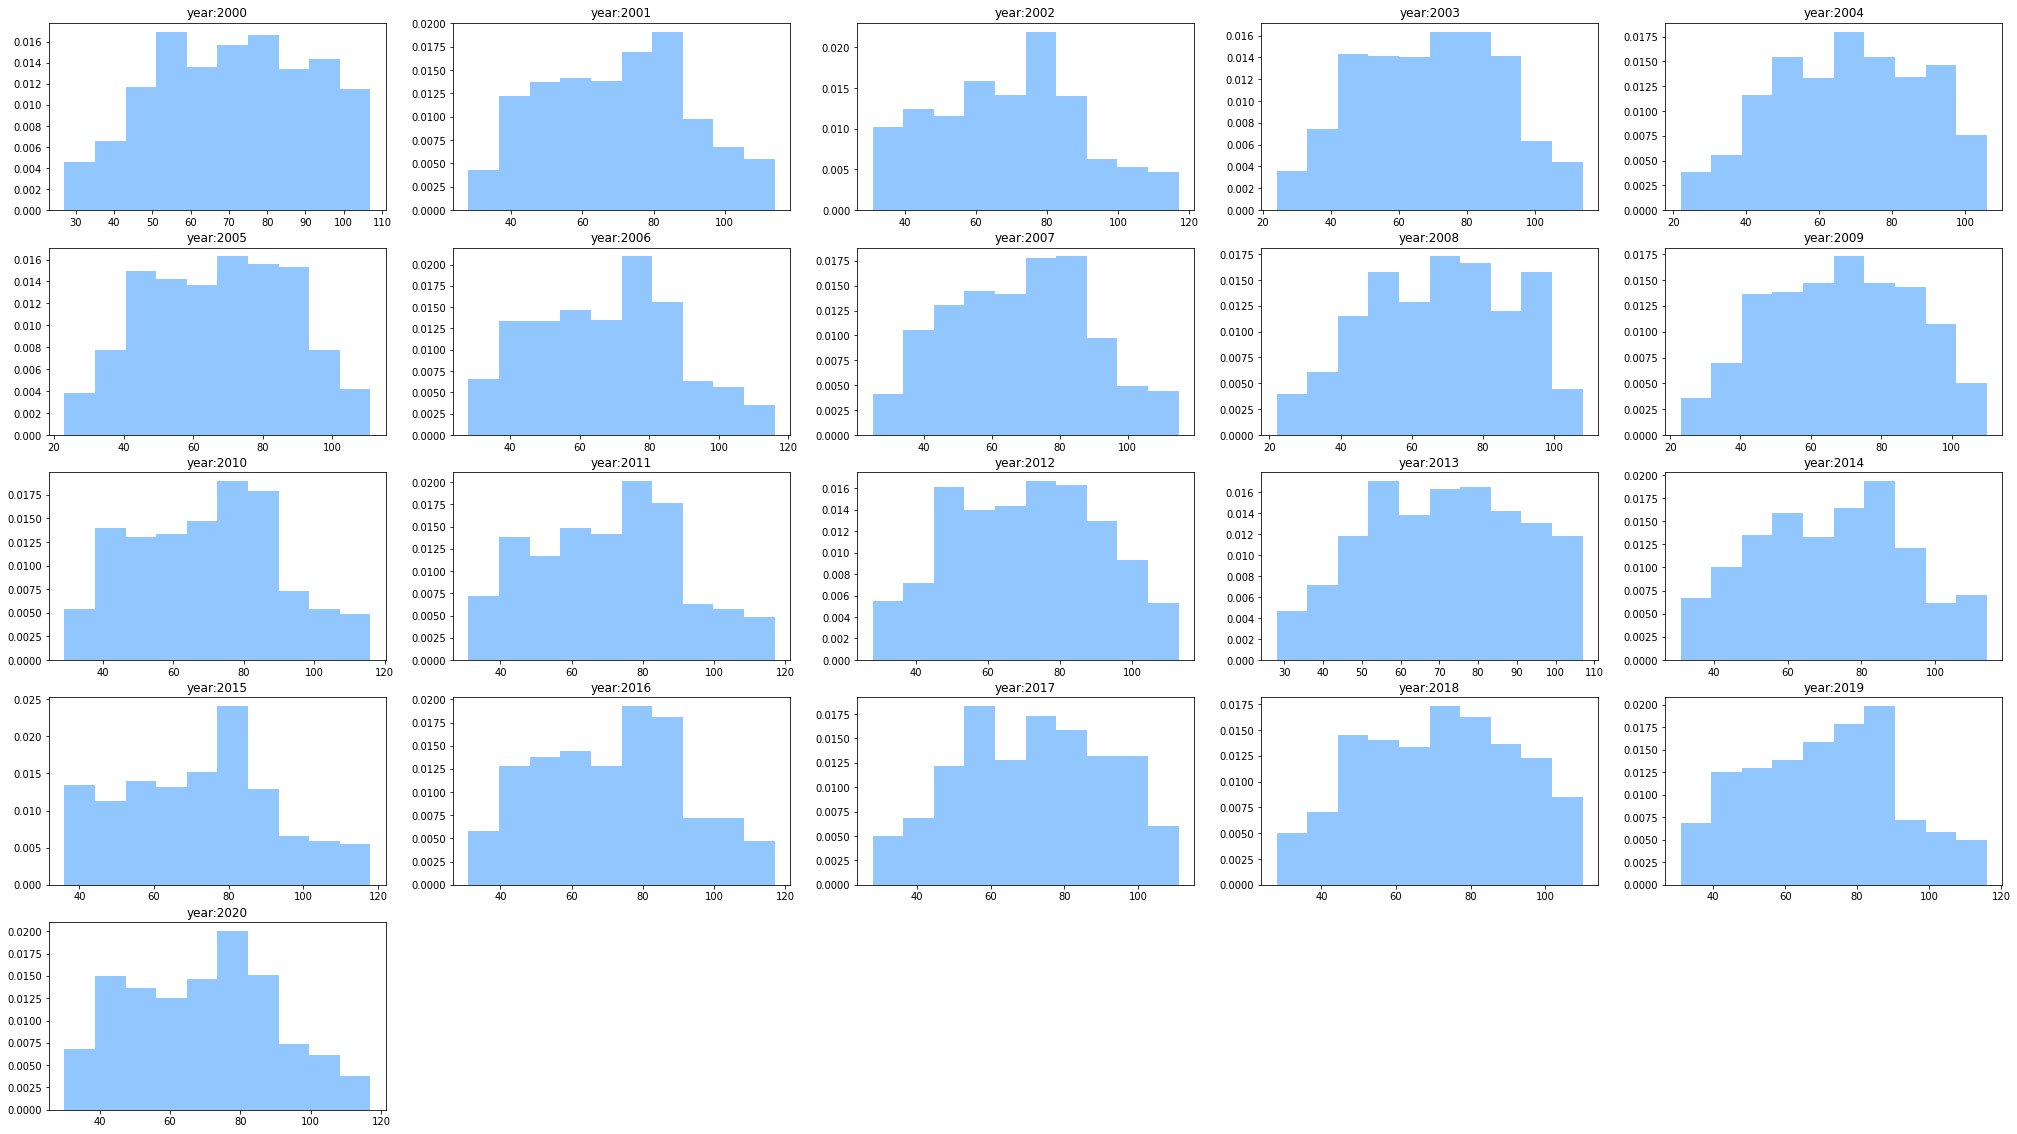

In [78]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.hist(data["coef"], density= True)
    plt.title("year:"+ str(years[i]))

# How does the coefficients change over a given month

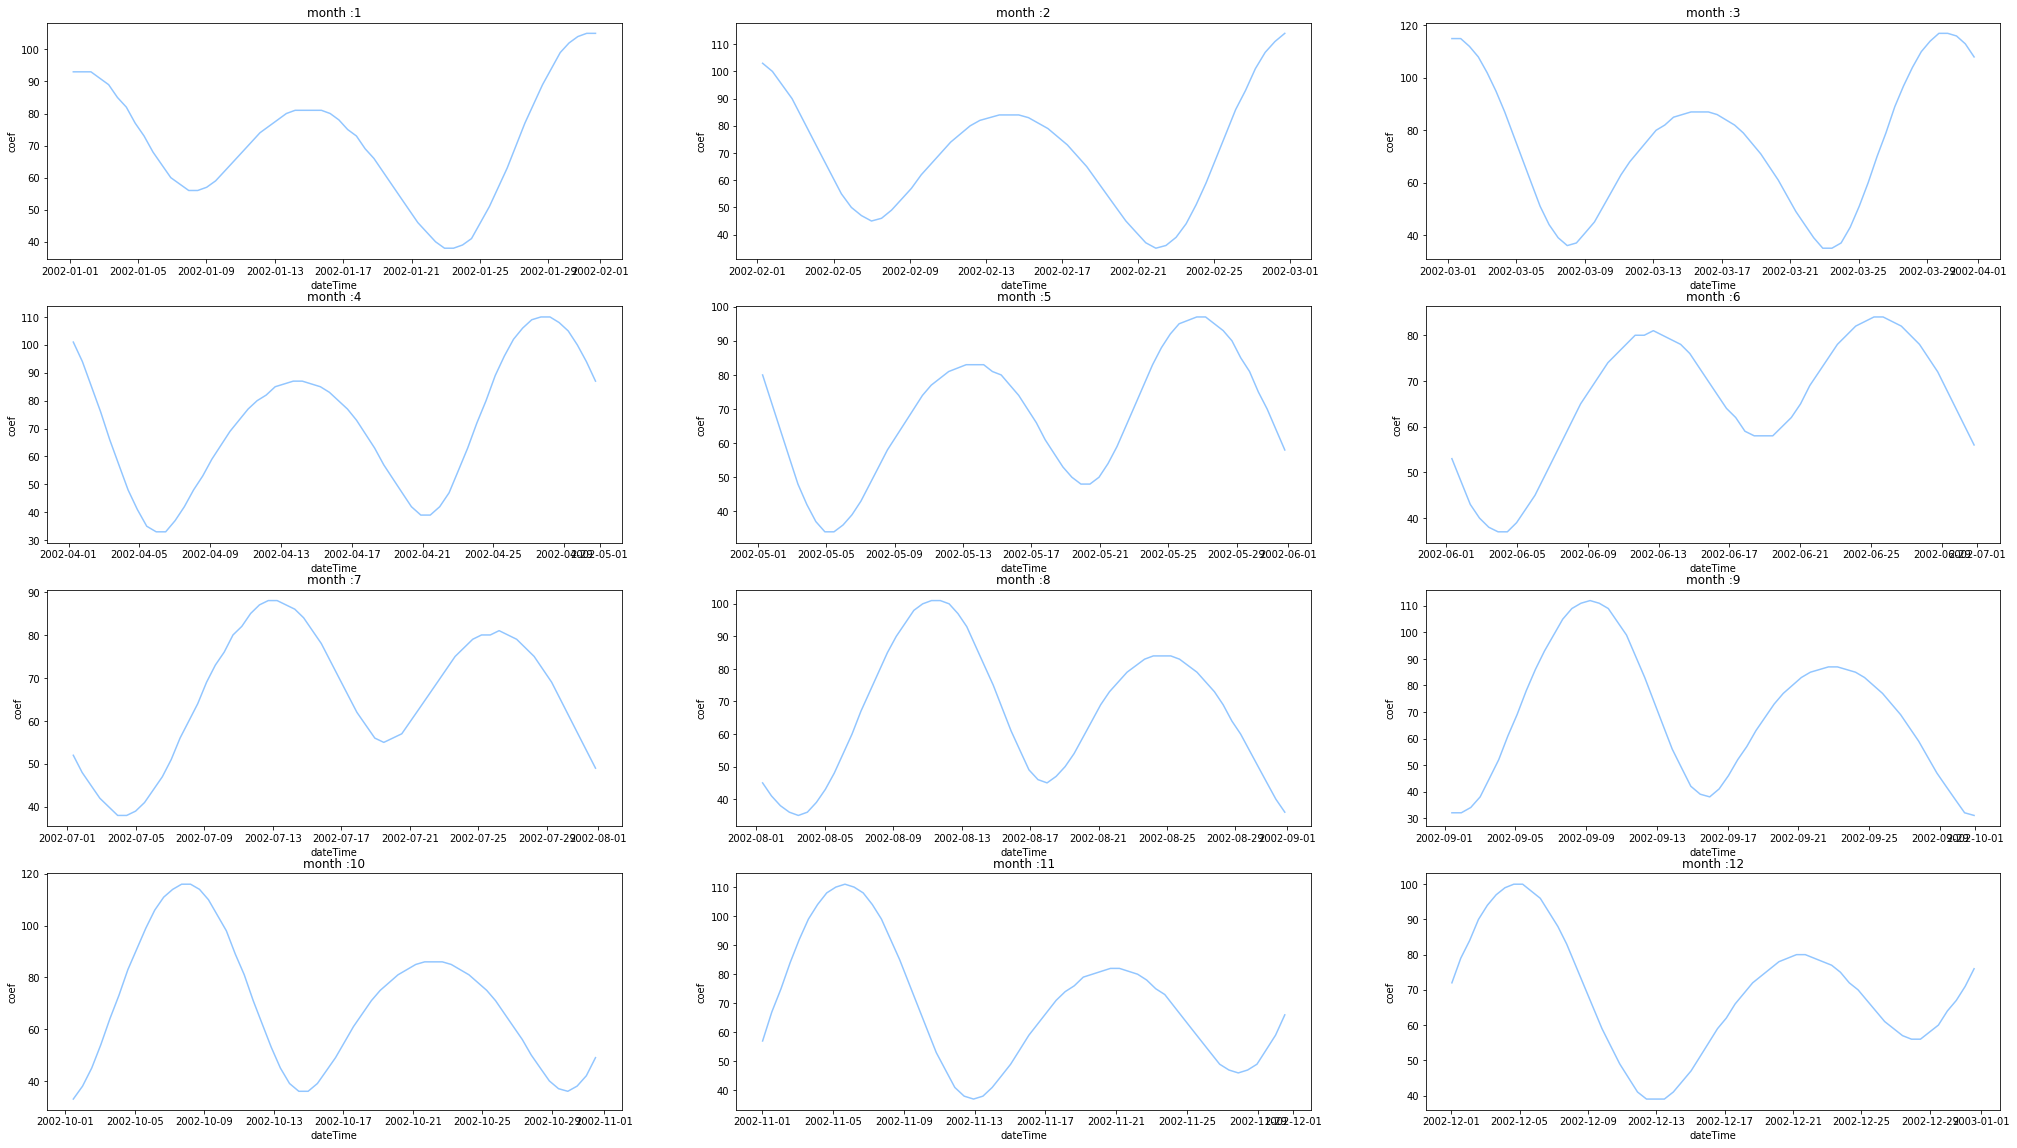

In [79]:
month = np.arange(1,13, 1)
plt.figure(figsize=(35,20))
for i in range(12):
    data = df[df["year"] == 2002]
    data = data[data["month"] == month[i]]
    plt.subplot(4,3,i+1)
    sns.lineplot(x="dateTime", y="coef", data=data)
    plt.title("month :"+ str(month[i]))

# Is there any relation between the variation of coefficients over a given month of two given years?

C:\Users\Otmane\AppData\Local\Temp/ipykernel_15200/76848444.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["year"]==2001][df["month"]==7]["coef"], df[df["year"]==2002][df["month"]==7]["coef"])


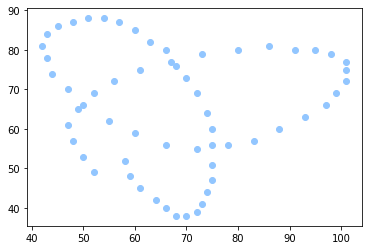

In [80]:
plt.scatter(df[df["year"]==2001][df["month"]==7]["coef"], df[df["year"]==2002][df["month"]==7]["coef"])

Strange??

# Is it stationary?


- Stationarity matters in practice for a number of reasons.

  A broader point is that a model of a time series that is not stationary will vary in its
  accuracy as the metrics of the time series vary.
  
  When forecasting or predicting the future, most time series models assume that each point is independent of one another. 
    
    The best indication of this is when the dataset of past instances is stationary

- In general, we want to make our serie stationary. 
    Like that we could model the trend and the sesonality. 

    Once these two componantes are modeled we could remove them from the time serie and then train models on the residuals.

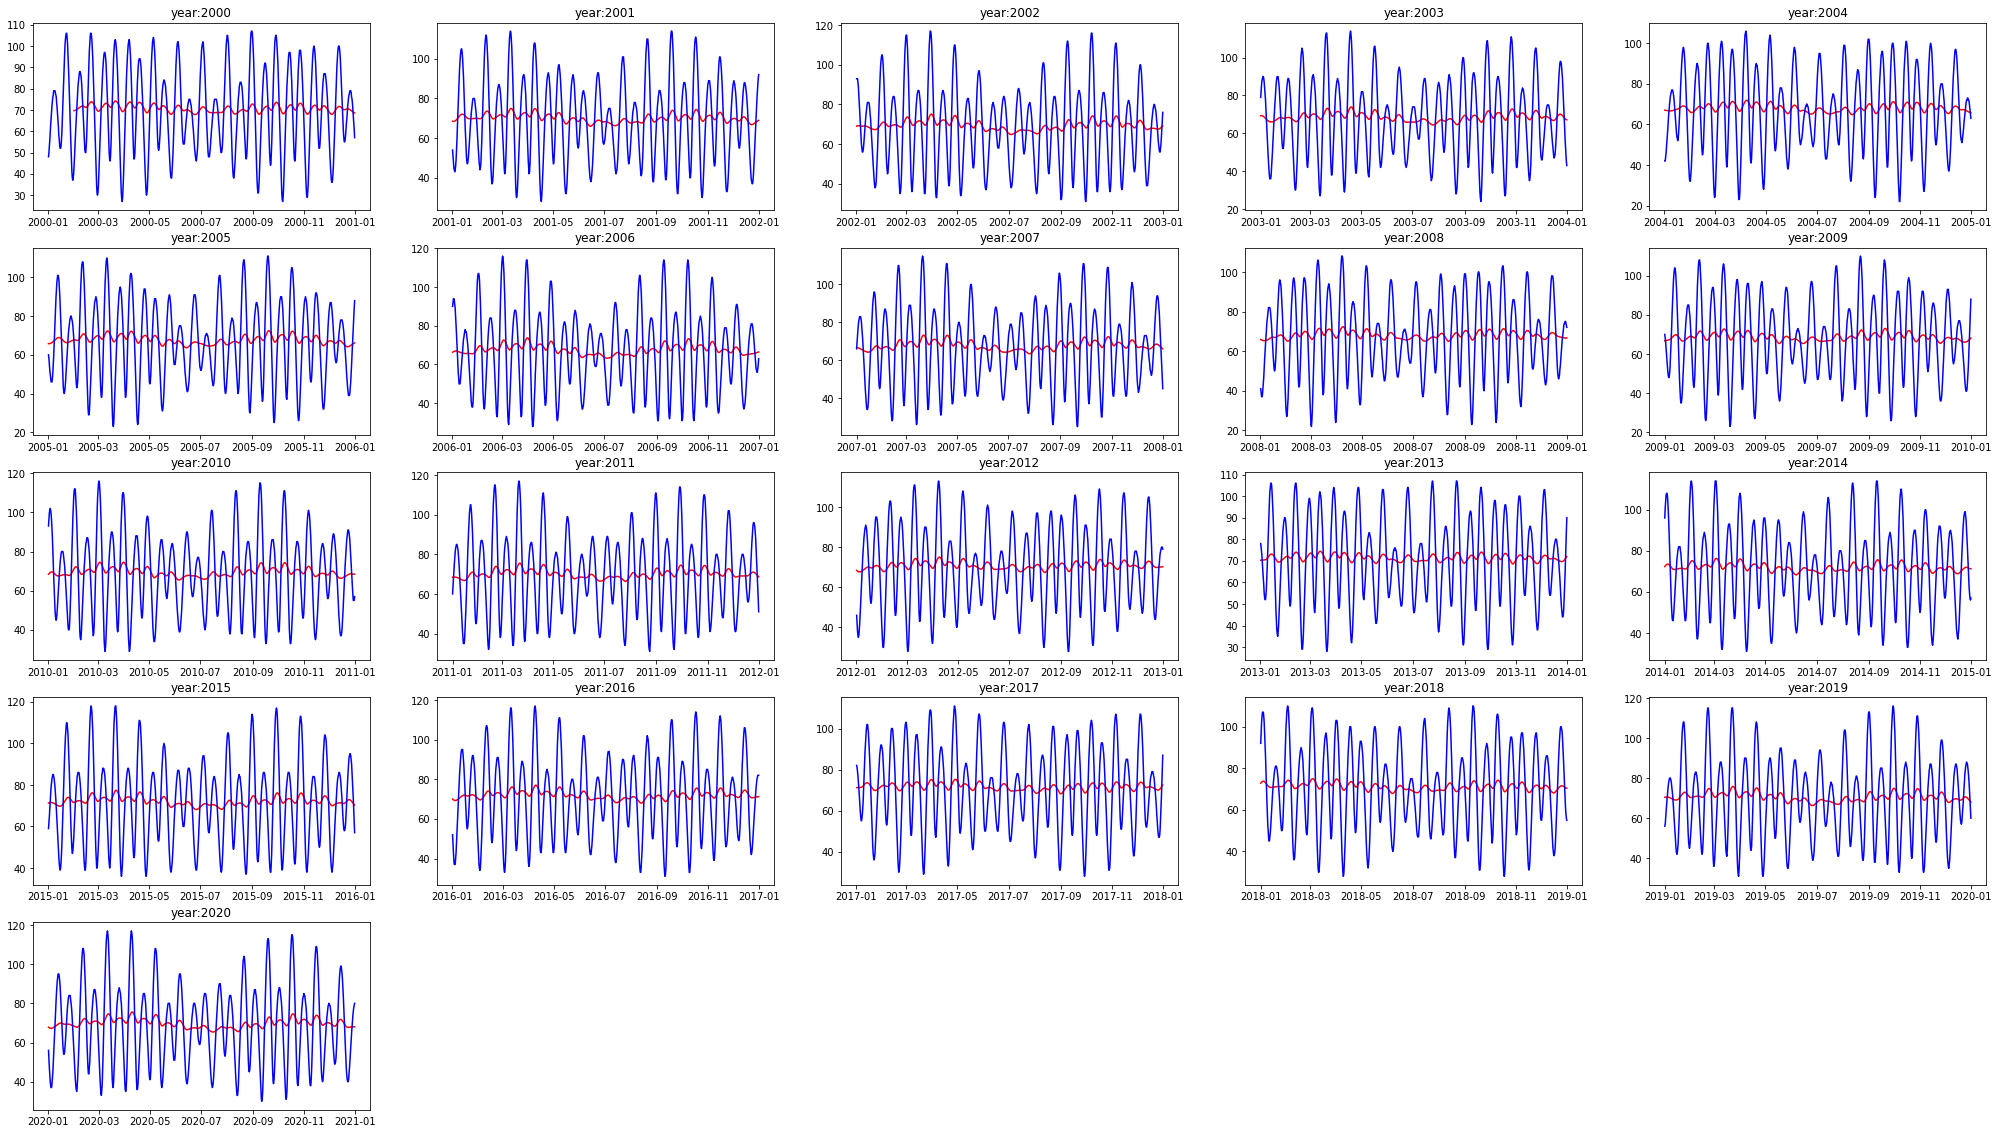

In [81]:
df['mean'] = df.loc[:,"coef"].rolling(window=60).mean() # Moving average of one month 
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["mean"], 'r-')
    plt.plot(data["dateTime"], data["coef"], color ='blue')
    plt.title("year:"+ str(years[i]))

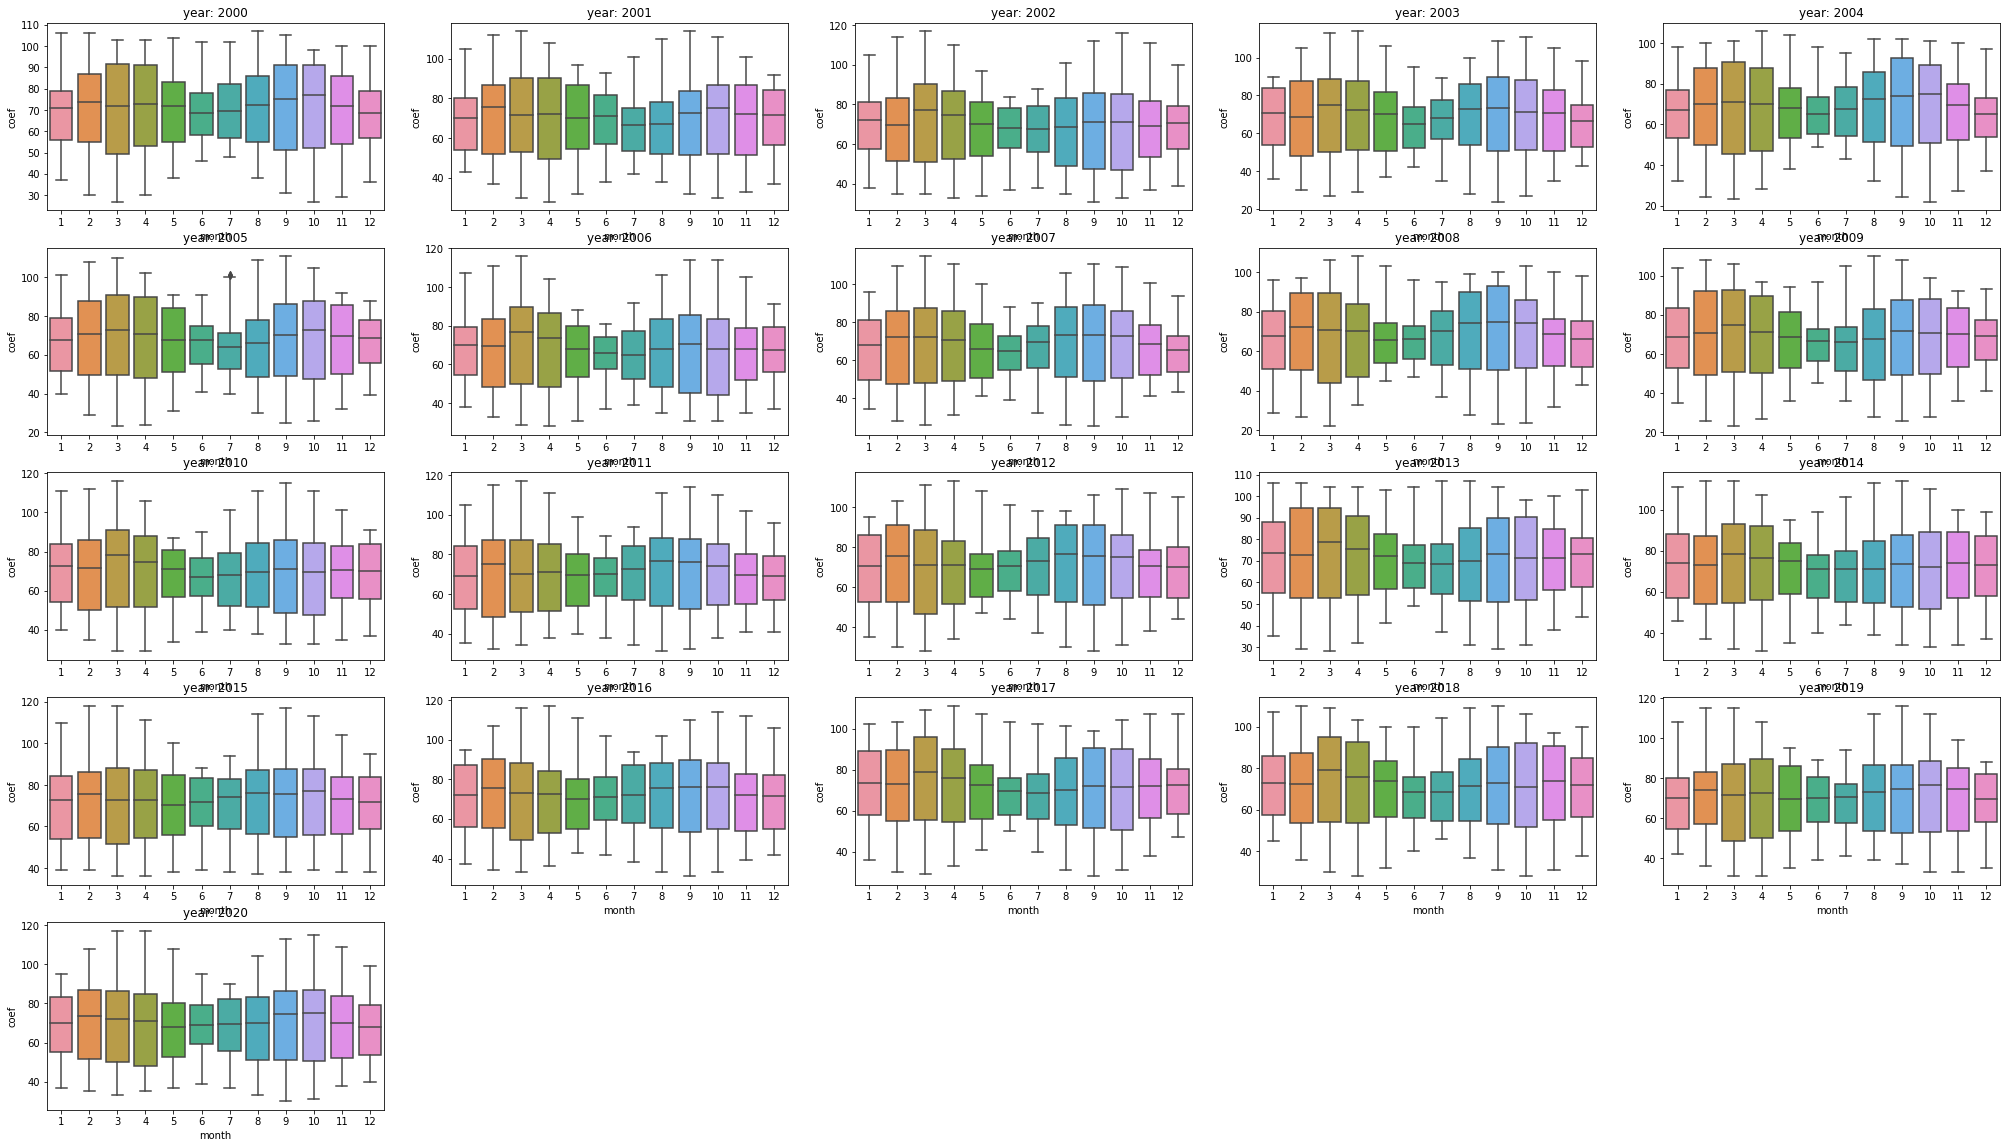

In [82]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    sns.boxplot(x="month", y="coef", data=data)
    plt.title("year: "+ str(years[i]))


- Well since the variance change over time! Also the past plots show a strong seasonal effect so we would say at this stage it is not stationary 
  Althoug the mean is basically constant !

Let's check using the Dicky-fuller test.

In [83]:
X = df["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.416285
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


the p-value of the test is 0 this suggests the rejection of the null hypothesis, which claims for non-stationarity

- Let's check for only one year

In [84]:
X = df[df["year"]==2020]["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.859436
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


So rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# Is there a seasonality?


Time series datasets can contain a seasonal component.

This is a cycle that repeats over time, such as monthly or yearly. 

This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

Text(0.5, 1.0, 'year:2000')

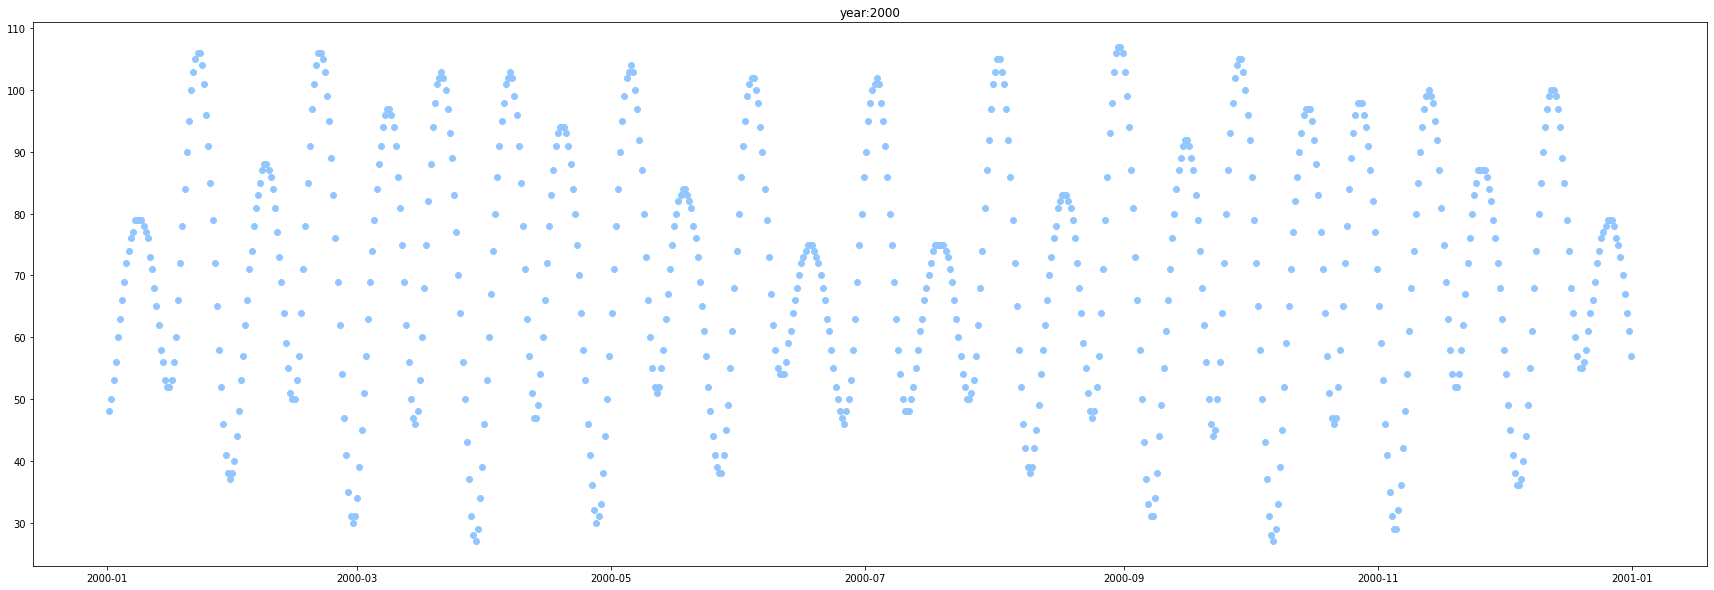

In [85]:
plt.figure(figsize=(30,10))
data = df[df["year"] == 2000]
plt.scatter(data["dateTime"], data["coef"])
plt.title("year:"+ str(2000))

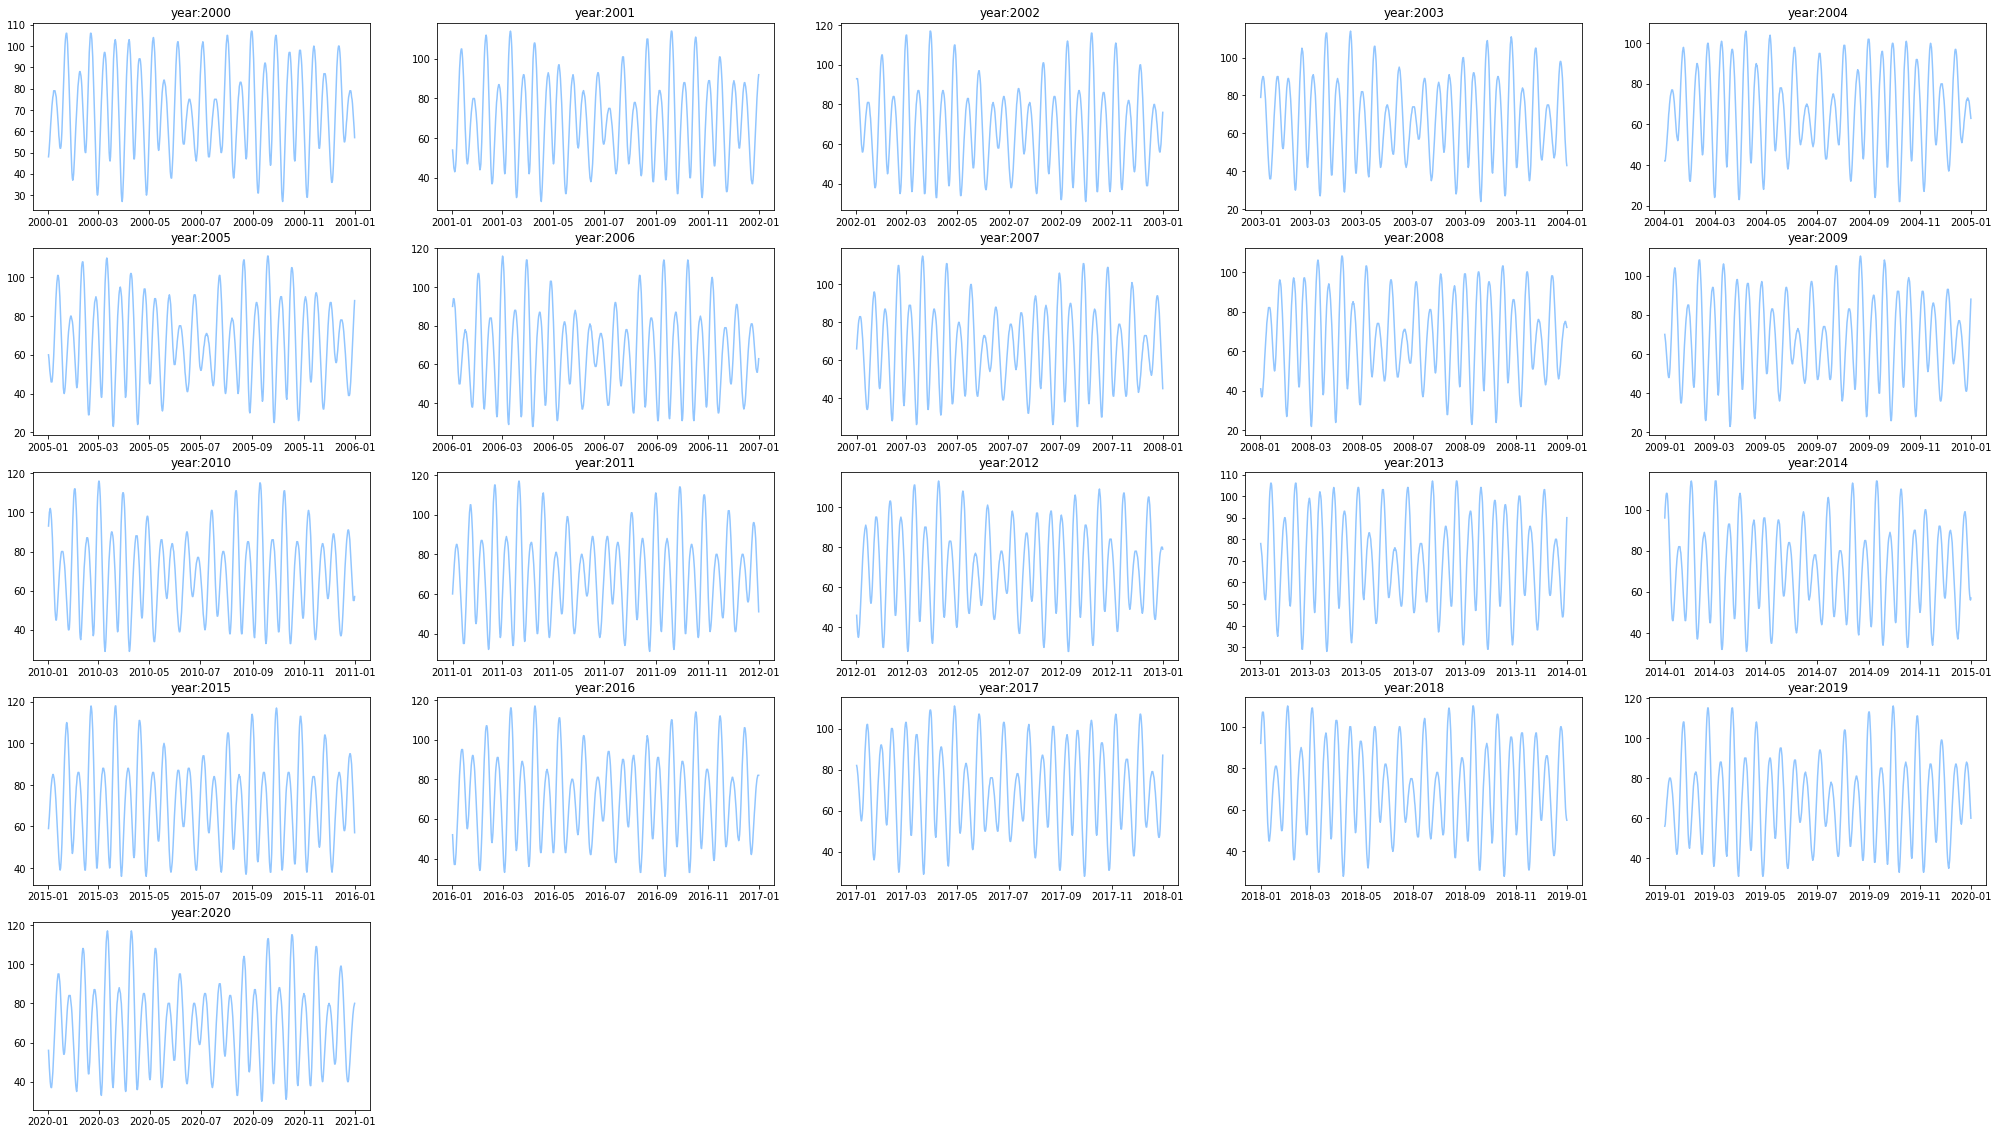

In [86]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["coef"])
    plt.title("year:"+ str(years[i]))

Seeing the plots above it seams that there is seasonality (6-month pattern),
but observing the last plot, we could say that our data is seasonal-stationary, let's check by computing the autocorrelation

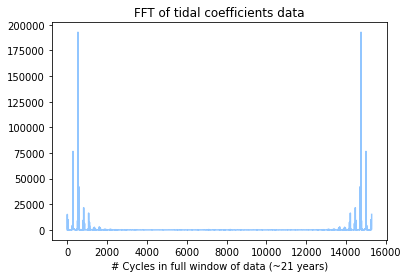

In [87]:
Fft = fft((df.coef - df.coef.mean()).values)
plt.plot(np.abs(Fft))
plt.title("FFT of tidal coefficients data")
plt.xlabel('# Cycles in full window of data (~21 years)');

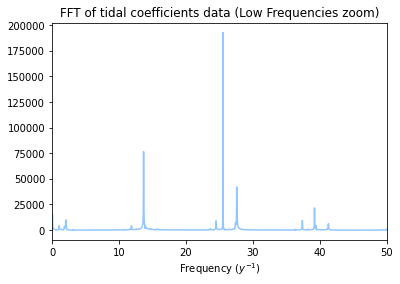

In [88]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([0,50])
plt.xlabel('Frequency ($y^{-1}$)');

- we see that there is a weekly seasonality

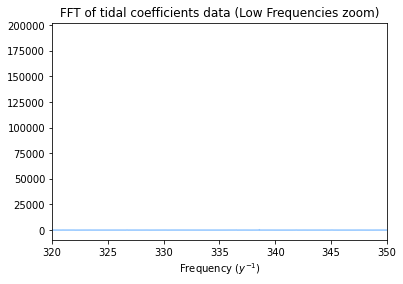

In [89]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([320,350])
plt.xlabel('Frequency ($y^{-1}$)');

- 13 day seasonality

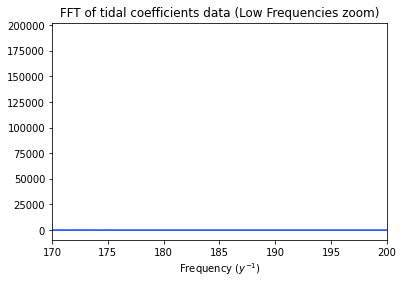

In [32]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([170,200])
plt.xlabel('Frequency ($y^{-1}$)');

- no 6 months seasonality

Let's check seasonality by plotting autocorrelation plot

Wikipedia def: 

    Autocorrelation, also known as serial correlation, is the correlation of a signal with a
    delayed copy of itself as a function of the delay. Informally, it is the similarity between
    observations as a function of the time lag between them.


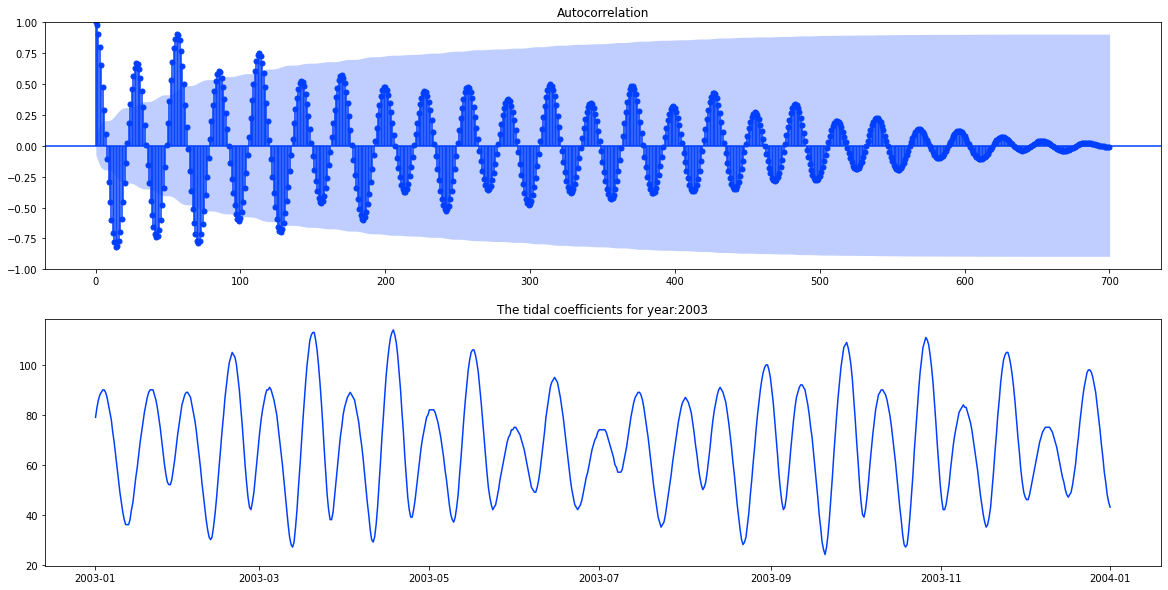

In [33]:
year = 2003
fig, ax = plt.subplots(2,1, figsize=(20,10))
plot_acf(df[df["year"]==year].coef, lags =700, ax=ax[0])
plt.plot(df[df["year"]==year].dateTime, df[df["year"]==year].coef)
plt.title("The tidal coefficients for year:" + str(year));

we see cycles of strong negative and positive correlation.

This captures the relationship of an observation with past observations.

Sine waves like those are a strong sign of seasonality in the dataset.

- An ACF fails to
    weed out these redundant correlations.
- The PACF, on the other hand, reveals which
    correlations are “true” informative correlations for specific lags rather than redun‐
    dancies. This is invaluable for knowing when we have collected enough information
    to get a sufficiently long window at a proper temporal scale for our data.

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


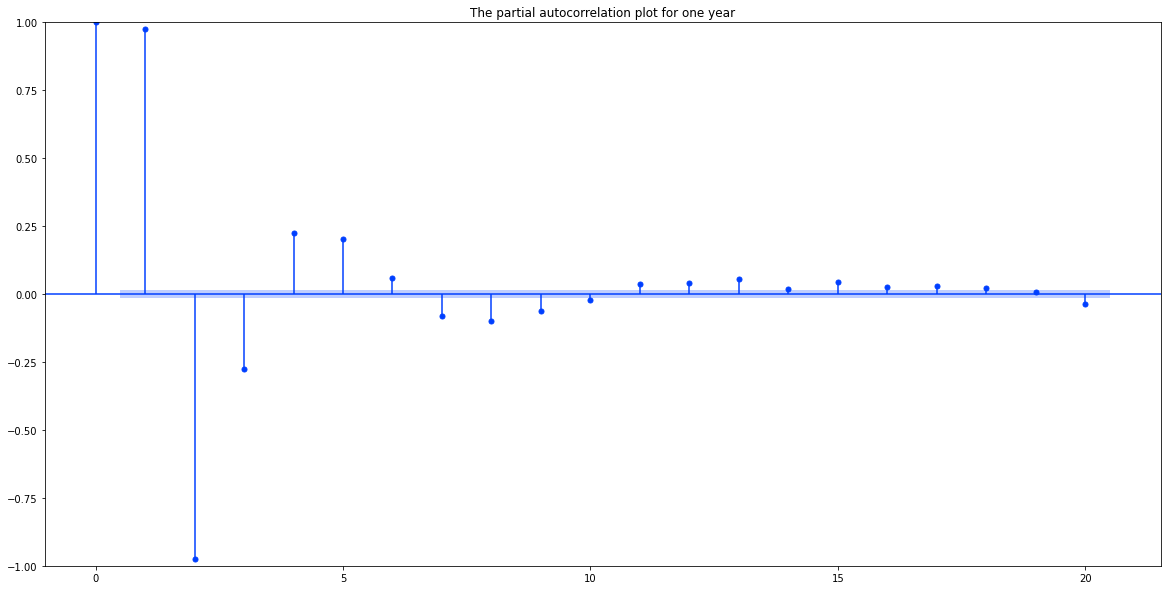

In [34]:
year = 2000
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df.coef, lags =20, ax = ax)
plt.title("The partial autocorrelation plot for one year");

# Problem Description

I' ll formulate the tidal coefficients forecasting as a supervised machine
learning task.

Given a time series containing N data points xt-(N+1);...; xt-1; xt, for M-step
ahead prediction. 

The input X of the supervised
ML model is xt-(N+1);....; xt-M, and the output Y is
xt-(M+1); xt-(M+2);...; xt.

Each data point xt can be a scalar
or a vector containing multiple features.

So it's a Seq2Seq problem.

So data must be prepared using the moving window technique to create features for the Seq2Seq model


### Evaluation metric

Several metrics are used in the litterature for time series forcasting, each metrics has it's advantages and drowbacks or limitation. And it's really context sensitive. Since this nootebook is exploratory. I'll go with the RMSE. And I'll evaluate each timeStamp individually. Which means RMSE for prediction of day1, RMSE for predicition day2...

In [35]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

### Data preparation

We will use the first 20 years of data for training predictive models and the final year for evaluating models.

The data will be divided into weeks, 14 values  (since for each day we've computed 2 values of the tidal coefficient). And the next 14 values would constitute the prediction target for the models.

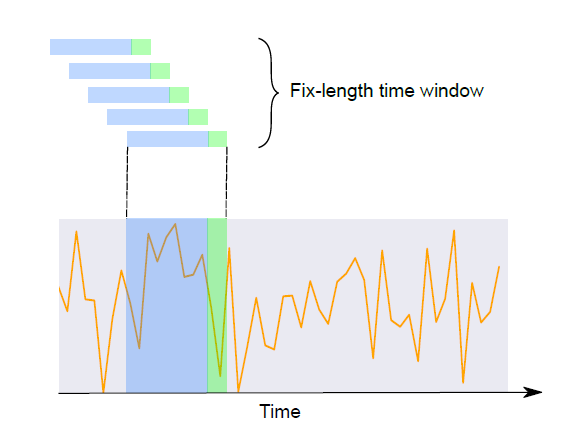

In [49]:
def split_dataset(data, past_values = 28, step = 14):
    """ Takes a dateTime with timeStamp and coef columns
        and creates train and test data by sliding a fixed size window
    """
    data['year'] = data['dateTime'].dt.year.values
    # split train and test
    train, test = data[data['year']!=2021].coef.values , data[data['year']==2021].coef.values
    # restructure into windows of weekly data
    X_train, y_train = [], []
    X_test, y_test = [], []
    train_shape = train.shape
    test_shape = test.shape
    print(train_shape)
    for row in range(0, train_shape[0]):
        if row+past_values+step <= train_shape[0]:
            X_train.append(train[row:row+past_values].reshape(past_values, 1))
            y_train.append(train[row+past_values:row+past_values+step])
    for row in range(0, test_shape[0]):
        if row+past_values+step <= test_shape[0]:
            X_test.append(test[row:row+past_values].reshape(past_values, 1))
            y_test.append(test[row+past_values:row+past_values+step])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [50]:
X_train, X_test, y_train, y_test = split_dataset(df.drop(axis=1,columns = ["month", "year", "day", "time", "hour", "mean"]))

(14822,)


### Models to test:

- ARIMA 
- RF
- LSTM
- Seq2Seq with attention

- If time allows Transformers


### RF: fast proof of concept

In [52]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape

In [53]:
RF = RandomForestRegressor(n_estimators = 100)
RF.fit(X_train.reshape(X_train_shape[0], X_train_shape[1]),y_train)

RandomForestRegressor()

In [54]:
y_predicted = RF.predict(X_test.reshape(X_test_shape[0],X_test_shape[1]))

In [55]:
y_test.shape

(429, 14)

In [56]:
y_predicted.shape

(429, 14)

In [57]:
score, scores = evaluate_forecasts(y_test, y_predicted)

the RMSE for all predictions is:2.6885795549527707
----------------------------------------------------------------------------------------------------


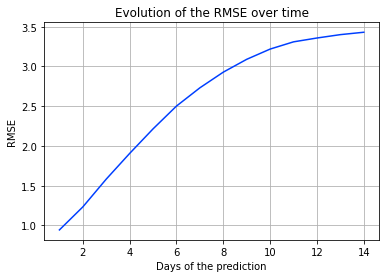

In [58]:
print("the RMSE for all predictions is:{}".format(score))

print("-"*100)

plt.plot(np.arange(14)+1, scores)
plt.xlabel("Days of the prediction")
plt.ylabel("RMSE")
plt.grid()
plt.title("Evolution of the RMSE over time");

### RF: Model Selection using the walk forward validation

The errors above indicate that our model performs well for the first value of the first day prediction and it does worse as we want to predict further steps in time. But Since the RMSE computed here has the same unit "roughly speaking: our actual value has no unit" 8 

Plotting actual versus predicted forcast of tidal coefficients

In [62]:
def plot_forcast(X, y, y_pred, data_index):
    plt.figure(figsize = (20,10))
    past_values = len(X[0])
    step = len(y[0])
    # Input 
    plt.scatter(np.arange(past_values)+1, X[i], color = "red")
    plt.plot(np.arange(past_values)+1, X[i], color = "red")

    # Ouptut (actual)
    plt.scatter(np.arange(past_values)+step+1, y[i], color = "red")
    plt.plot(np.arange(past_values)+step+1, y[i], color = "red", label = "actual")

    # Ouput (predicted)
    plt.scatter(np.arange(past_values)+step+1, y_pred[i], color ="blue")
    plt.plot(np.arange(past_values)+step+1, y_pred[i], color = "blue",  label = "predicted")

    # Decoration
    plt.axvline(x=step, color = "black")
    plt.axvspan(step, step+past_values, alpha=0.5, color='silver')
    
    plt.ylabel("Tidal coef value")
    plt.title("Foracast of {} days ahead using values from {} past days".format(step, past_values))
    plt.legend()
    plt.grid();
    

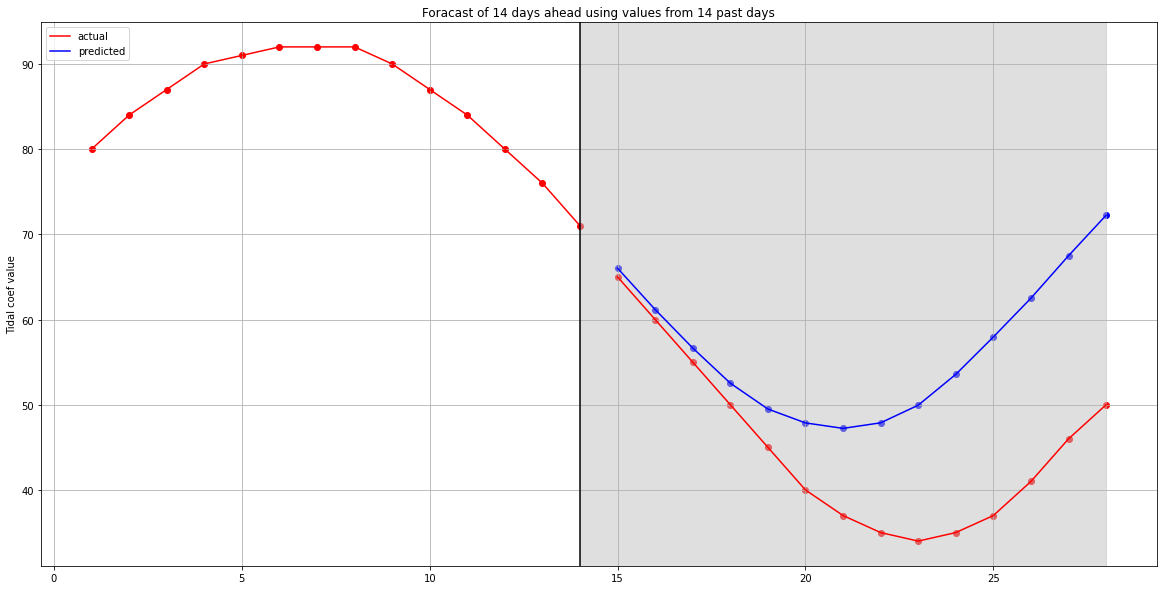

In [64]:
plot_forcast(X_test, y_test, y_predicted, 209)

### model selection using : Walk-Forward validation

[week1 values (14)] --> predict [week2 values (14)]

[week1 values (14) week2 values (14)] --> predict [week3 values (14)]
...

### LSTM

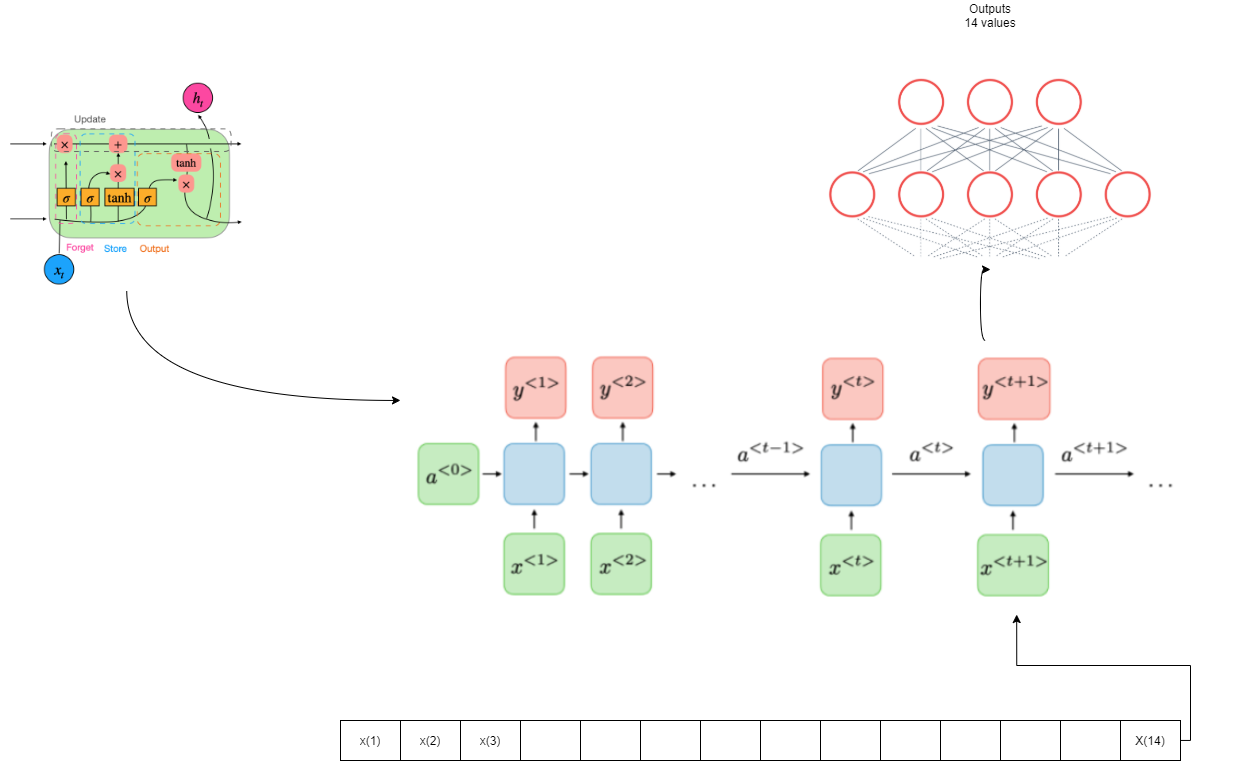

In [160]:
def build_model(train_x, train_y):
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    In = Input(shape = (n_timesteps, n_features))
    lstm = LSTM(200, activation='relu', return_sequences=False, input_shape=(n_timesteps, n_features))(In)
    d1 = Dense(100, activation='relu',)(lstm)
    outputs = Dense(n_outputs)(d1)
    model = Model(inputs = lstm, outputs = outputs)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model 

In [161]:
lstm_model = build_model(X_train, y_train)

NameError: name 'Input' is not defined